In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
def read_image(path,ismask = 0):
    path = path.decode()
    if(ismask == 1):
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        ret,img = cv2.threshold(img,70,255,0)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img/255.0
        img = np.expand_dims(img,axis = -1)
        img = img.astype(np.float32)
    else:
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img / 255.0
        img = img.astype(np.float32)
    return img

In [7]:
smooth = 1e-6
def dice_coeff(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - tf.compat.v1.reduce_mean(dice_coeff(y_true, y_pred))

In [8]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true) + K.sum(y_pred) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [9]:
"""
This is just trying to find a way to see if we could get the .h5 file to work with python 3.12 but it never worked
Disregard this bit
"""

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.
    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    with h5py.File(weight_file_path, "r") as f:
        if len(f.attrs.items()):
            print(f"{weight_file_path} contains: ")
            print("Root attributes:")
        for key, value in f.attrs.items():
            print(f"  {key}: {value}")

        if len(f.items()) == 0:
            return 

        # Now traverse each top-level group (layer) in the file
        for layer, g in f.items():
            print(f"  {layer}")
            print("    Attributes:")
            for key, value in g.attrs.items():
                print(f"      {key}: {value}")

            print("    Dataset(s):")
            for p_name in g.keys():
                param = g[p_name]
                if isinstance(param, h5py.Dataset):
                    # If it's scalar, use param[()]
                    if param.shape == ():
                        data = param[()]  # read scalar
                    else:
                        data = param[:]   # read array

                    print(f"      {p_name}: {data}")
                elif isinstance(param, h5py.Group):
                    print(f"      {p_name} is a group.")
                    # Optionally recurse or examine sub-items here
                else:
                    print(f"      {p_name}: Unknown item type.")

In [11]:
print_structure('Brain_hemorrhage_model_mask.h5')

Brain_hemorrhage_model_mask.h5 contains: 
Root attributes:
  backend: tensorflow
  keras_version: 2.13.1
  model_config: {"class_name": "Functional", "config": {"name": "model_3", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_4"}, "name": "input_4", "inbound_nodes": []}, {"class_name": "Lambda", "config": {"name": "lambda_3", "trainable": true, "dtype": "float32", "function": ["4wEAAAAAAAAAAAAAAAEAAAACAAAAQwAAAHMIAAAAfABkARsAUwApAk7p/wAAAKkAKQHaAXhyAgAA\nAHICAAAA+h4vdG1wL2lweWtlcm5lbF80Ny8zNjE4ODgzMDIucHnaCDxsYW1iZGE+AgAAAHMCAAAA\nCAA=\n", null, null], "function_type": "lambda", "module": "__main__", "output_shape": null, "output_shape_type": "raw", "output_shape_module": null, "arguments": {}}, "name": "lambda_3", "inbound_nodes": [[["input_4", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv2d_57", "trainable": true, "dtype": "float32",

In [18]:
from tensorflow.keras import layers, models, regularizers

def build_unet(input_shape=(128, 128, 3)):
    """
    Rebuilds a U-Net-like model based on the architecture from Brain_tumour_model_mask.h5.
    Make sure (128,128,3) matches the original training shape.
    """
    input_layer = layers.Input(shape=input_shape, name="input_4")

    # Lambda layer (lambda_3)
    x = layers.Lambda(lambda x: x, name="lambda_3")(input_layer)

    # ----- Encoder Block 1 -----
    conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_57")(x)
    conv1 = layers.BatchNormalization(name="batch_normalization_54")(conv1)
    conv1 = layers.Dropout(0.2, name="dropout_30")(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_58")(conv1)
    conv1 = layers.BatchNormalization(name="batch_normalization_55")(conv1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_12")(conv1)

    # ----- Encoder Block 2 -----
    conv2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_59")(p1)
    conv2 = layers.BatchNormalization(name="batch_normalization_56")(conv2)
    conv2 = layers.Dropout(0.3, name="dropout_31")(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_60")(conv2)
    conv2 = layers.BatchNormalization(name="batch_normalization_57")(conv2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_13")(conv2)

    # ----- Encoder Block 3 -----
    conv3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_61")(p2)
    conv3 = layers.BatchNormalization(name="batch_normalization_58")(conv3)
    conv3 = layers.Dropout(0.2, name="dropout_32")(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_62")(conv3)
    conv3 = layers.BatchNormalization(name="batch_normalization_59")(conv3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_14")(conv3)

    # ----- Encoder Block 4 -----
    conv4 = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_63")(p3)
    conv4 = layers.BatchNormalization(name="batch_normalization_60")(conv4)
    conv4 = layers.Dropout(0.2, name="dropout_33")(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                          kernel_initializer='he_normal', name="conv2d_64")(conv4)
    conv4 = layers.BatchNormalization(name="batch_normalization_61")(conv4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_15")(conv4)

    # ----- Bridge -----
    b = layers.Conv2D(1024, (3, 3), padding='same', activation='relu',
                      kernel_initializer='he_normal', name="conv2d_65")(p4)
    b = layers.BatchNormalization(name="batch_normalization_62")(b)
    b = layers.Dropout(0.2, name="dropout_34")(b)
    b = layers.Conv2D(1024, (3, 3), padding='same', activation='relu',
                      kernel_initializer='he_normal', name="conv2d_66")(b)
    b = layers.BatchNormalization(name="batch_normalization_63")(b)

    # ================= Decoder Blocks =================
    # ----- Decoder Block 1 -----
    d1 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same',
                                name="conv2d_transpose_12")(b)
    d1 = layers.Concatenate(name="concatenate_12")([d1, conv4])
    d1 = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_67")(d1)
    d1 = layers.BatchNormalization(name="batch_normalization_64")(d1)
    d1 = layers.Dropout(0.3, name="dropout_35")(d1)
    d1 = layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_68")(d1)
    d1 = layers.BatchNormalization(name="batch_normalization_65")(d1)

    # ----- Decoder Block 2 -----
    d2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',
                                name="conv2d_transpose_13")(d1)
    d2 = layers.Concatenate(name="concatenate_13")([d2, conv3])
    d2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_69")(d2)
    d2 = layers.BatchNormalization(name="batch_normalization_66")(d2)
    d2 = layers.Dropout(0.2, name="dropout_36")(d2)
    d2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_70")(d2)
    d2 = layers.BatchNormalization(name="batch_normalization_67")(d2)

    # ----- Decoder Block 3 -----
    d3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',
                                name="conv2d_transpose_14")(d2)
    d3 = layers.Concatenate(name="concatenate_14")([d3, conv2])
    d3 = layers.Dropout(0.2, name="dropout_37")(d3)
    d3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_71")(d3)
    d3 = layers.BatchNormalization(name="batch_normalization_68")(d3)
    d3 = layers.Dropout(0.15, name="dropout_38")(d3)
    d3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_72")(d3)
    d3 = layers.BatchNormalization(name="batch_normalization_69")(d3)

    # ----- Decoder Block 4 -----
    d4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',
                                name="conv2d_transpose_15")(d3)
    d4 = layers.Concatenate(name="concatenate_15")([d4, conv1])
    d4 = layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                       kernel_initializer='he_normal', name="conv2d_73")(d4)
    d4 = layers.BatchNormalization(name="batch_normalization_70")(d4)
    d4 = layers.Dropout(0.1, name="dropout_39")(d4)
    d4 = layers.Conv2D(
        64, (3, 3), padding='same', activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=regularizers.l2(1e-3),
        name="conv2d_74"
    )(d4)
    d4 = layers.BatchNormalization(name="batch_normalization_71")(d4)

    # ----- Final 1×1 output layer -----
    output_layer = layers.Conv2D(
        1, (1, 1), padding='valid', activation='sigmoid',
        kernel_regularizer=regularizers.l2(1e-2),
        name="conv2d_75"
    )(d4)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="model_3")
    return model

In [20]:
model_seg = build_unet(input_shape=(128,128,3))

# 3b) Compile with your custom objects (so you can train further, if you like)
model_seg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,  # or 'dice_loss'
    metrics=[dice_coeff, jacard_coeff]
)

# 3c) Load the weights from the .h5 file
model_seg.load_weights("Brain_hemorrhage_model_mask.h5")

print("Model built and weights loaded successfully!")

Model built and weights loaded successfully!


In [14]:
from keras.utils import custom_object_scope

with custom_object_scope({'dice_loss': dice_loss, 'dice_coeff': dice_coeff, 'jacard_coeff': jacard_coeff}):
    # Load your model
    model_seg = tf.keras.models.load_model('Brain_tumour_model_mask.h5')

In [28]:
img_path = cv2.imread('computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27.jpg')
img = cv2.resize(img_path, (128, 128))

In [29]:
mask_path = cv2.imread('computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27_HGE_Seg.jpg')

1/1 [==============================] - 0s 89ms/step


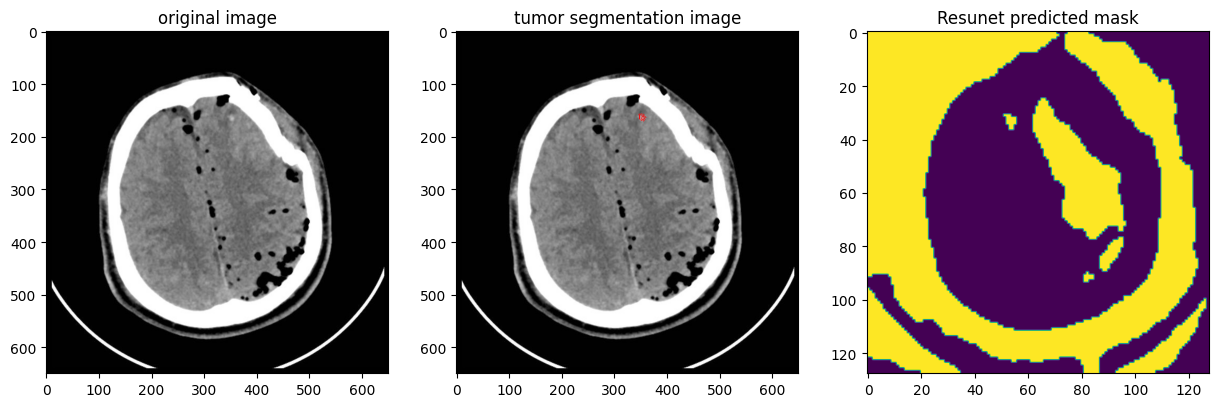

In [30]:
X = np.empty((1, 128, 128, 3))
# read the image
# resizing the image and coverting them to array of type float64
img = cv2.resize(img_path, (128, 128))
img = np.array(img, dtype=np.float64)

# standardising the image
img -= img.mean()
img /= img.std()
# converting the shape of image from 256,256,3 to 1,256,256,3
X[0,] = img

# make prediction of mask
predict = model_seg.predict(X)
# if sum of predicted mask is 0 then there is not tumour
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
#     original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
axs[0].imshow(original_img)
axs[0].title.set_text('original image')

#read predicted mask
pred = np.array(predict.squeeze().round())
axs[2].imshow(pred)
axs[2].title.set_text('Resunet predicted mask')

# read original mask
#     mask_img = cv2.imread(mask_path)
mask_img = cv2.cvtColor(mask_path, cv2.COLOR_BGR2GRAY)

# overlay original mask with MRI
original_img[mask_img == 255] = (255, 0, 0)
axs[1].imshow(original_img)
axs[1].title.set_text('tumor segmentation image')

plt.show()

1/1 [==============================] - 0s 260ms/step


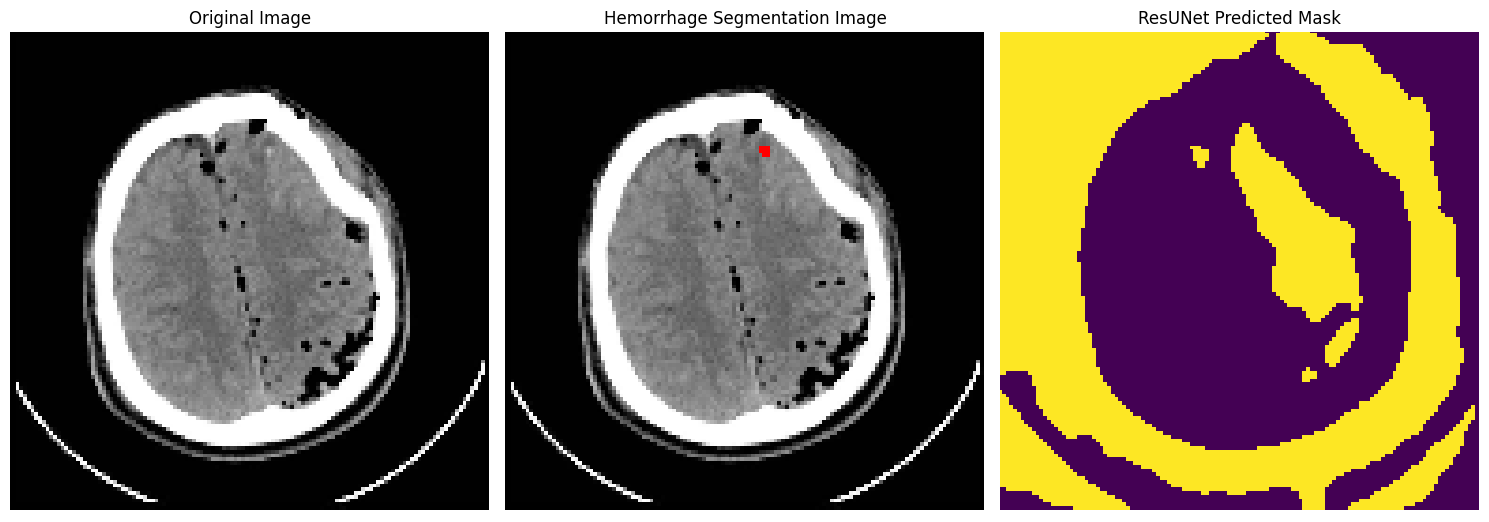

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# File paths 
img_path = 'computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27.jpg'
mask_path = 'computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27_HGE_Seg.jpg'

# --- 1. Load and preprocess CT image (grayscale → RGB) ---
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)            # Shape: (650, 650)
img_resized = cv2.resize(img_gray, (128, 128))                   # Shape: (128, 128)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)          # Shape: (128, 128, 3)
img_float = img_rgb.astype(np.float64)

# Standardize image
img_float -= img_float.mean()
img_float /= img_float.std()

# Add batch dimension for prediction
X = np.empty((1, 128, 128, 3))
X[0] = img_float

# --- 2. Run model prediction ---
predict = model_seg.predict(X)
pred_mask = predict.squeeze().round()                            # Shape: (128, 128)

# --- 3. Load and resize segmentation mask ---
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)               # Shape: (650, 650)
mask_resized = cv2.resize(mask, (128, 128))                      # Shape: (128, 128)

# --- 4. Create overlay image ---
overlay = img_rgb.copy()
overlay[mask_resized > 127] = (255, 0, 0)  # Red overlay for hemorrhage

# --- 5. Plot original, overlay, and predicted mask ---
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

axs[0].imshow(img_rgb)
axs[0].set_title('Original Image')

axs[1].imshow(overlay)
axs[1].set_title('Hemorrhage Segmentation Image')

axs[2].imshow(pred_mask)
axs[2].set_title('ResUNet Predicted Mask')

for ax in axs:
    ax.set_xlim(0, 128)
    ax.set_ylim(128, 0)
    ax.axis('off')

plt.tight_layout()
plt.show()